In [1]:
import numpy as np
from random import seed
from random import randrange

from dataloader import load_data
from PCA import PCA as pca
import matplotlib.pyplot as plt 
import matplotlib

In [2]:
def cross_val_one_class(k,dataset):
    k_sets = list()
    set_size = int(len(dataset)/k) 
    dataset_copy = list(dataset)
    
    for i in range(k-1):
        fold = list()
        while(len(fold)<set_size):
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        k_sets.append(fold)
        
    k_sets.append(dataset_copy)
        
    return k_sets

In [3]:
def cross_val_all_classes(k,dataset):
    k_sets = list()
    split = cross_val_one_class(k,dataset[0])
    
    for i in range(1,len(dataset)):
        split1 = cross_val_one_class(k,dataset[i])
        for j in range(k):
            split[j].extend(split1[j])
    
    return split        
        

In [4]:
def sigmoid(z):
    s = 1.0/(1+np.exp(-1.0*z))
    return s

In [5]:
def initialize_parameters(dim):
    """
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1))
    #w = np.random.randn(dim,1) * 0.0001
    #print(w.shape)
    b =0
    
    return [w, b]

In [6]:
def cost_function(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size dx1 
    b is the bias scalar
    
    n is the number of examples
    d is the dimension
    
    Returns:
    cost -- negative log-likelihood cost for logistic regression
    '''
    
    n = X.shape[0]
       
    z = np.dot(X,W) + b
    A = sigmoid(z) # activation function
    #cost = -1.0*np.sum(np.multiply(Y,log_y_hat))
    #J = -1.0*(np.multiply(Y,np.log(A)) + np.multiply((1-Y),np.log(1-A))
    #J = -1.0*((Y*np.log(A))+((1-Y)*np.log(1-A))) #cost_function
    #cost = np.sum(J)
    #cost = cost/n
    #cost = np.squeeze(cost)
    #print(cost)
    
    cost = (-1.0/n)*(np.dot(Y.T,np.log(A)) + np.dot((1-Y).T,np.log(1-A)))
    cost = np.squeeze(cost)
    
    return cost
    

In [7]:
def gradient_computation(W,b,X,Y):
    '''
    X is the input matrix of size nxd
    W is the weight matrix of size d1 
    b is the bias term
    Y is of size is nx1
    
    Returns gradients of parameters ws and w0 = b:
    dw -- gradient of the cost with respect to w, 
    db -- gradient of the cost with respect to b, 
    '''
    n = X.shape[0]
        
    z = np.dot(X,W) + b
    A = sigmoid(z) # activation function
    
    
    dw = (1/n)*np.dot(X.T,(A-Y))
    db = np.sum(A-Y)/n
    
    
    return [dw , db]

In [8]:
def batch_gradient_descent(w, b, X, Y, num_iterations, learning_rate, val_X,val_Y):
    '''
    X is the input train matrix of size dxn
    Y is the output train matrix of size nx1
    w is the weight matrix of size dx1
    b is the bias term, a scalar
    val_X , val_Y are validation matrices
    
    Returns:
    params w and b
    gradients dw and db
    value of cross_entropy_loss at each iteration for training set
    value of cross_entropy_loss at each iteration for validation set = holdout error
    '''
    costs = []
    total_cost = 0 
    
    prev_val_cost = 10000
    val_cost = 0
    val_costs = []
    val_cost_best = 0
    d1 = np.shape(X)[1]
    w_best = np.zeros((d1,1))
    b_best = 0
    
    
    for i in range(num_iterations):
        
        
        [dw,db] = gradient_computation(w,b,X,Y)
        
        # updating gradients
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Recording the costs
        
        cost = cost_function(w,b,X,Y)
        costs.append(cost)
        
        # Recording Val_cost and weights for lowest validation error
        
        val_cost = cost_function(w,b,val_X,val_Y)
        val_costs.append(val_cost)
        
        if  val_cost < prev_val_cost:
            w_best = w
            b_best = b
            val_cost_best = val_cost
            prev_val_cost = val_cost    
            
        # Print the cost every 10 training iterations
        if i % 10 == 0:
            print ("Training Cost after iteration %i: %f" %(i, cost))
           # print(w)
           # print (" Validation Cost after iteration %i: %f" %(i, val_cost))
            
    avg_loss = total_cost/num_iterations
    return [w,b,dw,db,costs,val_costs,w_best,b_best]
    
    

In [9]:
def predict_output(W, b, X):
    '''
    returns : 
    Y_prediction : all predictions (0/1) for the examples in X
    '''
    n = X.shape[0]
    d = X.shape[1]
    
    Y_prediction = np.zeros((n,1))
    
    z = np.dot(X,W) + b
    A = sigmoid(z) # output of sigmoid values for examples in X
     
    Y_prediction = np.where(A > 0.5, 1, 0)
    
    return Y_prediction

In [10]:
def compute_accuracy(Yp , Y):
    n = np.shape(Y)[0]
    m = 0
    for i in range(n):
        
        if(Y[i,0]==Yp[i,0]):
            m = m+1
    
    acc = m/n
    
    return acc

In [11]:
def Logistic_Regression_Model(X_train, Y_train, X_val, Y_val, X_test, Y_test, num_iterations, learning_rate):
    """
    dim is flattened image dimension
    n is number of examples
    
    X is the input train matrix of size  nxdim  
    Y is the output train matrix of size nx1
    w is the weight matrix of size dim x 1
    b is the bias term, a scalar
    X_val , Y_val are validation matrices
    X_test , Y_test are validation matrices
    
    Returns:
    d -- dictionary containing information about the model.
    """

    # initializing the parameters w and b
    
    dim = X_train.shape[1]
    [w,b] = initialize_parameters(dim)

    # Performing Batch Gradient descent on Training_Set
    [w_last,b_last,dw,db,costs,val_costs,w_best,b_best] = batch_gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate,X_val,Y_val)
    
   
    
    
    # Settings weights equal to the ones computed at the epoch when val cost is lowest
    w = w_best
    b = b_best
    
    # Predicting output for test and training sets
    
    Y_prediction_test = predict_output(w, b, X_test)
    Y_prediction_train = predict_output(w, b, X_train)
    Y_prediction_val = predict_output(w, b, X_val)
    
    # Calculating percentage accuracy for test and training sets
    
    train_accuracy = compute_accuracy(Y_prediction_train , Y_train)
    test_accuracy = compute_accuracy(Y_prediction_test , Y_test)
    val_accuracy = compute_accuracy(Y_prediction_val , Y_val)
    
     
    
    #print("Training Accuracy is : %f" %train_accuracy)
    
    print(train_accuracy)
    print(val_accuracy)
    print(test_accuracy)
    
    d = {"costs": costs,
         "val_costs": val_costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train,
         "Y_prediction_val" : Y_prediction_val,
         "w" : w, 
         "b" : b,
         "test_accuracy" : test_accuracy,
         "train_accuracy" : train_accuracy,
         "val_accuracy" : val_accuracy
         }
    
    return d

In [12]:
def flatten_dataset(dataset):
    '''
    Gets input data set as the list of 2 lists, each having mxn images coressponding to each class
    Output returns similar list but with all the images flattened into 1-D array
    '''
    f_data = list()
    for i in range(2):
        dt = dataset[i]
        [m,n] = np.shape(dt[0])
    
        for j in range(len(dataset[i])):
            dt1 = dt[j].reshape(1,m*n)
            dt2 = np.zeros((1,(m*n)+1))
            #print(np.shape(dt2))
            dt2[0,0:m*n] = dt1
            dt2[0,-1] = 1-i # adding value of output Y to the list
            dt[j] = dt2
    
        f_data.append(dt)
        
    return f_data     

In [13]:
def kfolds_to_karrays(k_folds):
    # each k-fold[i] is a list containing some number of 1-d arrays
    # converting list of k-folds into k 2-d arrays
    
    d = np.shape(k_folds[0][0])[1]
    #print(d)
    new_kfolds = list()
    for i in range(len(k_folds)):
        kf = np.zeros((len(k_folds[i]) , d)) 
        for j in range(len(k_folds[i])):
            kf[j,:] = k_folds[i][j]
        new_kfolds.append(kf) 

    # shuffle the elements in each k-set

    for i in range(len(new_kfolds)):
        np.random.shuffle(new_kfolds[i])
    
    return new_kfolds 
    

In [14]:
def split_data_into_X_Y(new_kfolds):
    #convert each k set into X and Y
    k_foldsX = list()
    k_foldsY = list()

    for i in range(len(new_kfolds)):
    
        kX = new_kfolds[i][:,0:-1]
        #print(np.shape(kX))
        k_foldsX.append(kX)
    
        n = np.shape(kX)[0]
        kY = np.zeros((n,1))
        kY[:,0] = new_kfolds[i][:,-1]
        k_foldsY.append(kY)
        
    return [k_foldsX , k_foldsY]
    
    

In [15]:

# Evaluating Softmax_Regression Model on Aligned dataset
[d1, d2] = load_data(data_dir="./resized/")

# Loading the dataset
dt_c = d1['Convertible']
dt_m = d1['Minivan']


# Dividing data into k=10 sets with each set containing roughly equal number of examples from each class

dataset = list()
dataset.append(dt_c)
dataset.append(dt_m)


# Flattening all the images

f_data = flatten_dataset(dataset)

        
k = 10
k_folds = cross_val_all_classes(k,f_data) 

# each k-fold[i] is a list containing some number of 1-d arrays
# converting list of k-folds into k 2-d arrays

new_kfolds = kfolds_to_karrays(k_folds)

#convert each k set into X and one-hot Y

[k_foldsX,k_foldsY] = split_data_into_X_Y(new_kfolds)    


Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images


In [16]:
for i in range(k):
    print(np.shape(k_foldsX[i]))

(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)
(30, 60000)


In [17]:
# Evaluating Logistic_Regression Model on Resized dataset lr1 = 0.001
#Spliting k_folds into train and test arrays



# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()



    
#Splitting into train,val and test set 80/10/10
    
val_X = k_foldsX[0] 
val_Y = k_foldsY[0]
    
test_X = k_foldsX[1]
test_Y = k_foldsY[1]
    
train_X = k_foldsX[2]
train_Y = k_foldsY[2]
for j in range(3,10):
    train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
    train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)
    
#batch gradient decscent for training

train_X = train_X/255
val_X = val_X/255
test_X = test_X/255
    
# d is a dictionary
d = Logistic_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 0.001)
    
# test accuracy for this particular iteration of k_fold
test_accuracy = d['test_accuracy']
Val_accuracy = d['val_accuracy']
Train_accuracy = d['train_accuracy']


print('Test accuracy is %f'%test_accuracy)
print('Validation_accuracy is %f'%Val_accuracy)




Training Cost after iteration 0: 0.687986
Training Cost after iteration 10: 1.439067
Training Cost after iteration 20: 1.375950
Training Cost after iteration 30: 1.308357
Training Cost after iteration 40: 1.240452
Training Cost after iteration 50: 1.174597
Training Cost after iteration 60: 1.112156
Training Cost after iteration 70: 1.053813
Training Cost after iteration 80: 0.999767
Training Cost after iteration 90: 0.949904
Training Cost after iteration 100: 0.903930
Training Cost after iteration 110: 0.861462
Training Cost after iteration 120: 0.822093
Training Cost after iteration 130: 0.785421
Training Cost after iteration 140: 0.751075
Training Cost after iteration 150: 0.718722
Training Cost after iteration 160: 0.688077
Training Cost after iteration 170: 0.658903
Training Cost after iteration 180: 0.631004
Training Cost after iteration 190: 0.604228
Training Cost after iteration 200: 0.578453
Training Cost after iteration 210: 0.553588
Training Cost after iteration 220: 0.529561

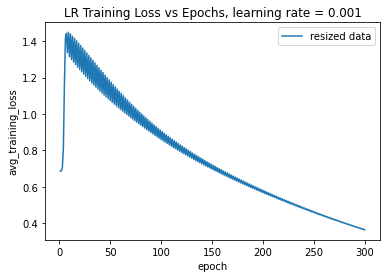

In [18]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = d['costs']

iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "resized data")
plt.xlabel('epoch')
plt.ylabel('avg_training_loss')
plt.title('LR Training Loss vs Epochs, learning rate = 0.001') 


plt.legend()
plt.show() 

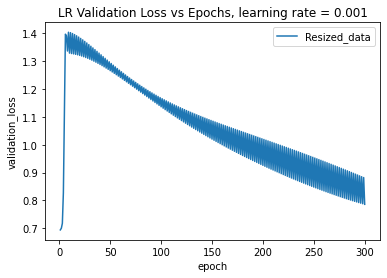

In [19]:
# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()

val_costs = d['val_costs']

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "Resized_data")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
plt.title('LR Validation Loss vs Epochs, learning rate = 0.001')

plt.legend()    
plt.show() 



In [20]:
# Evaluating Logistic_Regression Model on Resized dataset lr1 = 0.002

# Adding PCA Components np(no. of components) = 14  


# Training Procedure
num_iter = 300
total_test_accuracy  = 0
test_accuracies = np.zeros((10,1))
val_losses = np.zeros((10,1))
val_cost_list = list()
train_cost_list = list()



    
#Splitting into train,val and test set 80/10/10
    
val_X = k_foldsX[0] 
val_Y = k_foldsY[0]
    
test_X = k_foldsX[1]
test_Y = k_foldsY[1]
    
train_X = k_foldsX[2]
train_Y = k_foldsY[2]
for j in range(3,10):
    train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
    train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)


#applying PCA on train_X
[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(train_X,14)
train_X = projected
    
# transforming val_X and test_X using eigenvectors from above
mean_image = np.average(val_X, axis = 0)
msd = val_X - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
val_X = projected

mean_image = np.average(test_X, axis = 0)
msd = test_X - mean_image # M x d
projected = np.matmul(msd, top_eigen_vectors)/top_sqrt_eigen_values
test_X = projected

#batch gradient decscent for training

train_X = train_X/255
val_X = val_X/255
test_X = test_X/255
    
# d is a dictionary
d = Logistic_Regression_Model(train_X, train_Y, val_X, val_Y,test_X,test_Y, 300, 0.002)
    
# test accuracy for this particular iteration of k_fold
test_accuracy = d['test_accuracy']
Val_accuracy = d['val_accuracy']
Train_accuracy = d['train_accuracy']


print('Test accuracy is %f'%test_accuracy)
print('Validation_accuracy is %f'%Val_accuracy)




Training Cost after iteration 0: 0.693147
Training Cost after iteration 10: 0.693147
Training Cost after iteration 20: 0.693147
Training Cost after iteration 30: 0.693147
Training Cost after iteration 40: 0.693147
Training Cost after iteration 50: 0.693147
Training Cost after iteration 60: 0.693147
Training Cost after iteration 70: 0.693147
Training Cost after iteration 80: 0.693147
Training Cost after iteration 90: 0.693147
Training Cost after iteration 100: 0.693147
Training Cost after iteration 110: 0.693147
Training Cost after iteration 120: 0.693147
Training Cost after iteration 130: 0.693147
Training Cost after iteration 140: 0.693147
Training Cost after iteration 150: 0.693147
Training Cost after iteration 160: 0.693147
Training Cost after iteration 170: 0.693147
Training Cost after iteration 180: 0.693147
Training Cost after iteration 190: 0.693147
Training Cost after iteration 200: 0.693147
Training Cost after iteration 210: 0.693147
Training Cost after iteration 220: 0.693147

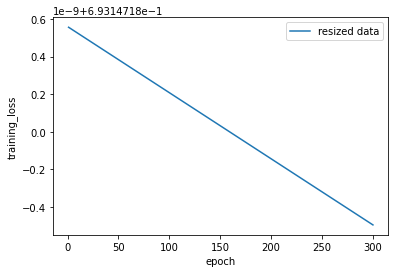

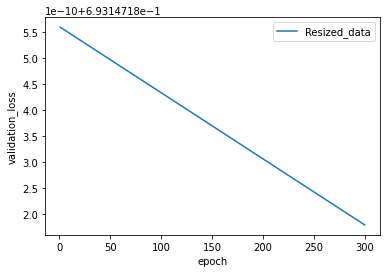

In [21]:
#print(test_accuracies)
# plotting Avg_Training Loss
costs = d['costs']

iters = list(range(1, num_iter+1))
#print(Avg_Train)
plt.plot(iters,costs,  label = "resized data")
plt.xlabel('epoch')
plt.ylabel('training_loss')
#plt.title('Train_Loss vs Epochs, lrn_rate = 0.002, n_comp = 14') 


plt.legend()
plt.show() 

# plotting Avg_Val_Loss
#costs = Avg_Train_loss.tolist()

val_costs = d['val_costs']

iters = list(range(1, num_iter+1))

plt1 = plt.plot(iters,val_costs,  label = "Resized_data")
plt.xlabel('epoch')
plt.ylabel('validation_loss')
#plt.title('lrn_rate = 0.002, n_comp = 14')

plt.legend()    
plt.show() 




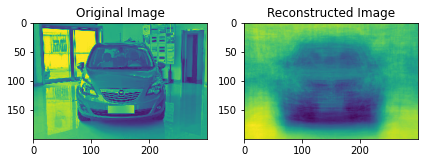

0.0


In [22]:
# Visualizing principal components of 10th image in train_X
# let X be k_foldsX[0] and take first example image from X and diaplay the principal components

# PLOTTED IMAGE BELONGS TO CLASS 1 i.e minivan
train_X = k_foldsX[2]
train_Y = k_foldsY[2]
for j in range(3,10):
    train_X = np.concatenate((train_X,k_foldsX[j]), axis=0)
    train_Y = np.concatenate((train_Y,k_foldsY[j]), axis=0)


X1 = train_X

mean_image = np.average(X1, axis = 0)

[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X1,4)
X_reduced = projected

#Reconstructing using top 4 eigenvalues
X_rec = np.matmul(X_reduced[:,0:4]*top_sqrt_eigen_values[0:4],top_eigen_vectors[:,0:4].T) + mean_image

#print(np.shape(X_rec))
X1 = X1[10].reshape((200,300))
X_rec = X_rec[10].reshape((200,300))

# creating image object of above array

fig=plt.figure()
imgs = []
imgs.append(X1)
imgs.append(X_rec)
rows = 1
cols = 2
axes=[]
title = []
title.append('Original Image')
title.append('Reconstructed Image')
for a in range(rows*cols):
    b = imgs[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(title[a])
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()
print(train_Y[0][0])
# PLOTTED IMAGE BELONGS TO CLASS 2 AS kfoldsY[0][2] = [0,1,0,0] 

[0.39355931 0.23222318 0.20856995 0.16564756]
[128555.78229185  75855.48513933  68129.18155891  54108.62071988]


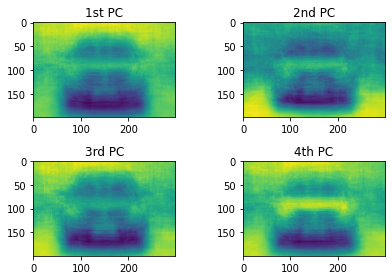

[1.]


In [23]:
# Showing each principal component individually
X_recs = []
imgs = []
X1 = train_X
#print(np.shape(X1))
mean_image = np.average(X1, axis = 0)

[projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors] = pca(X1,4)
X_reduced = projected

print(top_sqrt_eigen_values[0:4]/np.sum(top_sqrt_eigen_values))
print(top_sqrt_eigen_values[0:4])
for i in range(4):
    #Reconstructing using top ith eigenvalue
    Xr1 = np.zeros((240,1))
    Xe1 = np.zeros((1,60000))
    Xr1[:,0] = X_reduced[:,i]*top_sqrt_eigen_values[i]
    Xe1[0,:] = top_eigen_vectors[:,i].T
    
    X_reconstruct = np.matmul(Xr1,Xe1) + mean_image
    X_recs.append(X_reconstruct)
    
    X_recs[i] = X_recs[i][10].reshape((200,300))
    
    


fig=plt.figure()
imgs = X_recs

rows = 2
cols = 2
axes=[]
title = []
title.append('1st PC')
title.append('2nd PC')
title.append('3rd PC')
title.append('4th PC')

for a in range(rows*cols):
    b = imgs[a]
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=(title[a])
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
fig.tight_layout()    
plt.show()

print(k_foldsY[0][0])
    